In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import scipy

import importlib
import os, sys

from sklearn import preprocessing
#from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel, ExpSineSquared
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss, r2_score
import GPy
from scipy.linalg import solve_continuous_lyapunov, cho_factor, cho_solve, expm

sys.path.append(os.path.abspath('../../visualization'))
from plotters import plot_gp, plot_gpkf, plot_gpkf_space_time, plot_residuals, animate_heatmap
from kernel import Kernel, Matern32, Matern52, RBF, Exponential, Periodic, AddedKernels
from params import Params
from metrics import print_metrics
from gpkf import Gpkf
from generateSyntheticData import generateSyntheticData

from crossValidation import TimeSplitter, cv_prediction
#from plotters import plot_gp, plot_gp_example, plot_residuals

In [2]:
df = pd.read_csv('../../data/mergedData.csv')
df.set_index('Timestamp', inplace=True)
df.index = pd.to_datetime(df.index)
df = df.asfreq('1Min')
df['dateTime'] = df.index
df.index = np.around(df.index.to_julian_date() * 24 * 60)
df.index = df.index - df.index[0]

#X_train, X_test, y_train, y_test = train_test_split(df.index.values, df.values , test_size=0.2, shuffle= False)

In [3]:
center_df = df[[col for col in df.columns if 'Pos1' in col and 'DO' in col]] #.dropna(axis = 0, how = 'all')
#center_df = df['Pos1m3DO'].dropna(axis=0)
#center_df

In [4]:
"""
plot_gpkf_space_time(params, F, posteriorMean, posteriorCov, predictedMean, predictedCov, 1000, 7)
plt.savefig('test'+'.png')
samples = np.random.multivariate_normal(posteriorMean[0,:].ravel(), posteriorCov[0,:,:], 1)
plot_gpkf(params.data['TimeInstants'], [], [], posteriorMean[0, :], posteriorCov[0,0,:], samples=samples)"""

"\nplot_gpkf_space_time(params, F, posteriorMean, posteriorCov, predictedMean, predictedCov, 1000, 7)\nplt.savefig('test'+'.png')\nsamples = np.random.multivariate_normal(posteriorMean[0,:].ravel(), posteriorCov[0,:,:], 1)\nplot_gpkf(params.data['TimeInstants'], [], [], posteriorMean[0, :], posteriorCov[0,0,:], samples=samples)"

# Initial, approximate spatial locations

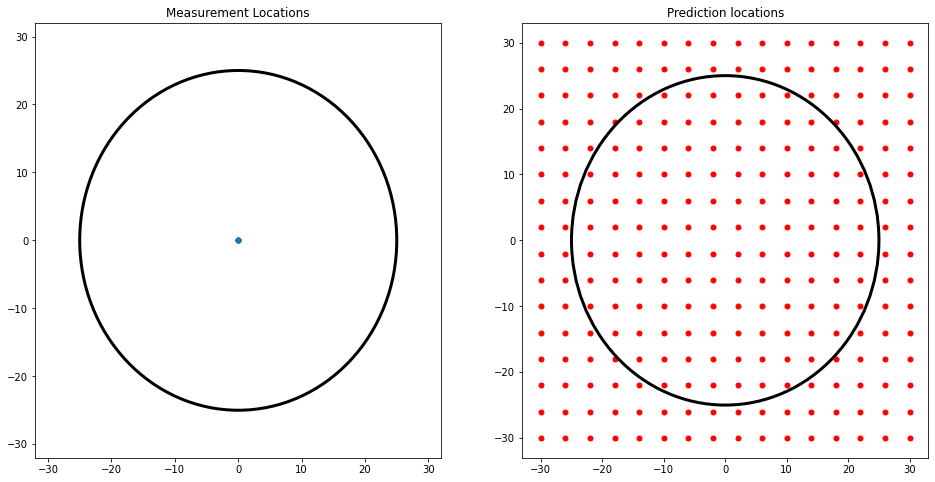

In [20]:
#df_do = df[[col for col in df.columns if 'DO' in col]]
df_do = df[['Pos1m3DO', 'Pos1m6DO', 'Pos1m9DO', 'Pos1m12DO']]
locations = df_do.iloc[0]
locations = locations.astype('object')
center = 0
for col in locations.index:
    depth = int(re.search('m\d+', col).group()[1:])  # Get sensor depth
    if 'Pos1' in col:
        locations[col] = np.array([center, depth, center])
    elif 'Pos4' in col:
        locations[col] = np.array([center +21, depth, center])
    elif 'Pos5' in col:
        locations[col] = np.array([center-2, depth, center+21])
    elif 'Pos6' in col:
        locations[col] = np.array([center - 20, depth, center+5])
    elif 'Pos7' in col:
        locations[col] = np.array([center-7, depth, center-19])
    elif 'Pos12' in col:
        locations[col] = np.array([center, depth, center])
    elif 'Pos21' in col:
        locations[col] = np.array([center-20, depth, center+2])
    elif 'Pos22' in col:
        locations[col] = np.array([center-27, depth, center])
    elif 'Pos23' in col:
        locations[col] = np.array([center-21, depth, center])
    elif 'Pos31' in col:
        locations[col] = np.array([center + 2, depth, center + 20])
    elif 'Pos32' in col:
        locations[col] = np.array([center, depth, center+27])
    elif col == 'Outsidem3DO':
        locations[col] = np.array([center-30, depth, center])
    elif col =='SouthOutsidem3DO':
        locations[col] = np.array([center, depth, center -29])
    elif col =='Northm3DO':
        locations[col] = np.array([center, depth, center+21])
    elif col =='Southm3DO':
        locations[col] = np.array([center, depth, center-21])
        
# Symmetric standardization of locations
spaceLocsMeas = np.stack(locations.values)
scaler = preprocessing.StandardScaler().fit(spaceLocsMeas)
spaceLocsMeas = scaler.transform(spaceLocsMeas)

# Create and prediction locations
pred_shape = 16
xx, yy, zz = np.meshgrid(np.arange(-30,31,4), 3, np.arange(-30,31,4))
#xx, yy, zz = np.meshgrid(30, np.arange(1,14,1), 30)
#xx, yy, zz = np.meshgrid(center, 3, np.arange(0,60,1))
spaceLocsPred = np.column_stack([xx.flatten(), yy.flatten(), zz.flatten()])

# Plot measurement/prediction locations
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(121)

locs = np.vstack(locations.values)
ax1.scatter(locs[:,0], locs[:,2], s = 25)

cage_circle=plt.Circle((center, center),25,color='black', fill=False, linewidth = 3)
plt.gcf().gca().add_artist(cage_circle)
plt.xlim(-32, 32)
plt.ylim(-32, 32)
plt.title("Measurement Locations")
ax2 = fig.add_subplot(122)
locs = np.vstack(Xp)
#ax1.scatter(locs[:,0], locs[:,2], s = 25, color = 'r')
ax2.scatter(locs[:,0], locs[:,2], s = 25, color = 'r')
cage_circle2=plt.Circle((center, center),25,color='black', fill=False, linewidth = 3)
plt.gcf().gca().add_artist(cage_circle2)
plt.title("Prediction locations")
spaceLocsPred = scaler.transform(spaceLocsPred)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_do.index.values, df_do.values, test_size=0.25, shuffle= False)

# Formatting of measurements (spatial locations, timesteps)

In [15]:
Y = df_do.to_numpy().T
Y_train = Y[:,:len(X_train)]
Y_train_timeInstants = df_do.index[:len(X_train)]

Y_test = Y[:,len(X_train):]
Y_test_timeInstants = df_do.index[len(X_train):]

# Testing kernel kernel combination code

In [94]:
print('Initializing Model')
# create time kernel
kernel_time = Matern32(input_dim = 1, lengthscale=511.759408, variance = 58.9173407) + Periodic(input_dim = 1, variance = 5.57957089, lengthscale = 0.0757490469, period = 750.022794)
#kernel_time = Matern32Kernel(input_dim = 1, lengthscale=112.30548, variance = 43.19)
# create space kernel
#kernel_space = Gaussian(input_dim=3, variance=7.00980776e+01, lengthscale=[1.63285388e-01, 6.25592884e-01, 1.16242257e-03], ARD = True)
#kernel_space = Matern32(input_dim=3, variance=24.683550498250008, lengthscale=[0.183469555, 0.470256520, 0.000846486749] , ARD = True)
#kernel_space = RBF(input_dim=3, variance=24.683550498250008, lengthscale=[0.183469555, 0.470256520, 0.000846486749] , ARD = True)
kernel_space = RBF(input_dim=1, variance=0.5, lengthscale=5 , ARD = False)
# [296.94573008 166.6765845  292.16929161   0.90729993 286.01831043 60.13856892 291.60828253   8.7336094 ]
model_ID = 0 #get_model_ID("models.txt")
model = Gpkf(kernel_time, kernel_space, alpha =0.1, normalize_y = True, ID = model_ID)

#[2.08360759e+03 1.00000000e-03 2.81339554e+00 1.00000000e-03]

Initializing Model


 C:\Users\Lars Martin\.conda\envs\oxygenModel\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


# Center test

In [24]:
spaceLocsMeas = np.array([3,6,9,12]).reshape(-1,1)
scaler = preprocessing.StandardScaler().fit(spaceLocsMeas)
spaceLocsMeas = scaler.transform(spaceLocsMeas)

# Set up prediction locations
#xx, yy, zz = np.meshgrid(0, np.arange(1, 14, 0.5), 0)
#pred_loc =  scaler.transform(np.column_stack([xx.flatten(), yy.flatten(), zz.flatten()]))
#[7.16330837e+01 5.09180122e+02 3.56828458e+00 7.49964092e+02 8.82888590e-02 5.49109721e+01 1.83469555e-01 4.78145385e-01 1.00000000e-03]

In [95]:
model.fit(spaceLocsMeas, Y_train_timeInstants, Y_train, optimize = True, fun = 'nll', n_restarts = 2)

 C:\Users\Lars Martin\Documents\Master\gaussianProcess\GPKF\gpkf.py:357: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


KeyboardInterrupt: 

In [96]:
model.kernel_space.kernel

rbf.,value,constraints,priors
variance,0.5,+ve,
lengthscale,5.0,+ve,


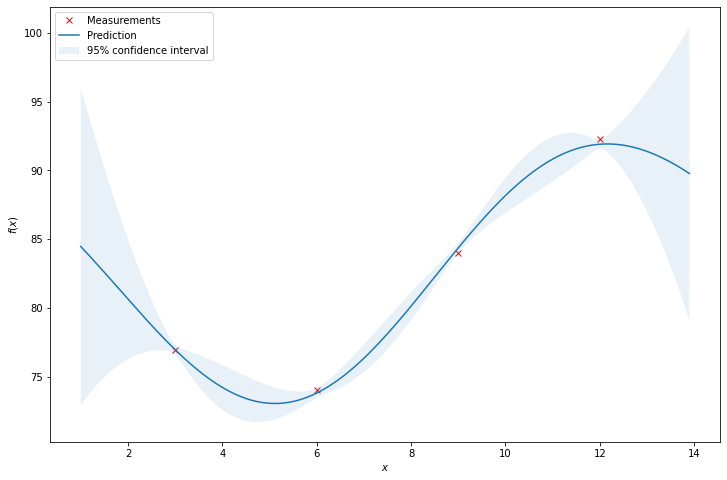

In [100]:
#[2.09978738e+00 2.27705647e+01 1.54911022e+03 4.20048055e-02]
model.kernel_space.set_hyperparams([10, 1.5])
posteriorMean, posteriorCov, logMarginal = model.estimate(Y_train, prediction= True)
predictedMean, predictedCov = model.predict(scaler.transform(np.arange(1,14,0.1).reshape(-1,1)), model.y_train_timeInstants)
timeStamp = 1000
plt.figure(figsize=(12,8))
plot_gpkf(np.arange(1,14,0.1), np.array([3,6,9,12]), Y_train[:, timeStamp], predictedMean[:,timeStamp], predictedCov[:,:,timeStamp], **{'linestyle' : 'None', 'marker': 'x'})

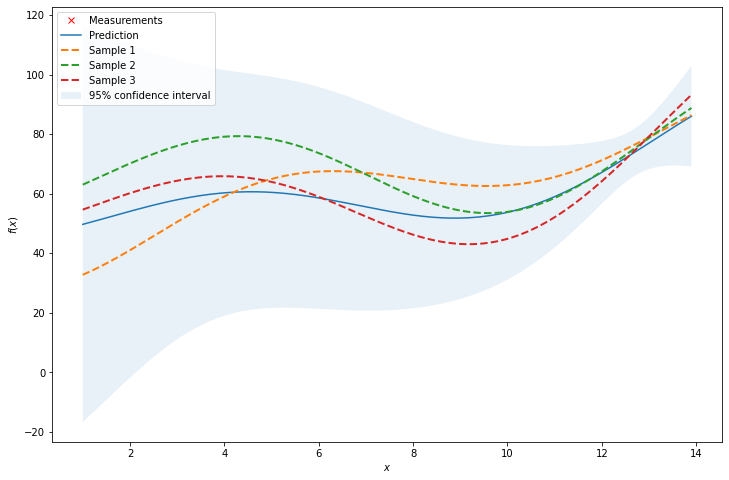

In [93]:
timeStamp = 1500
ys = np.random.multivariate_normal(mean = predictedMean[:,timeStamp], cov = predictedCov[:,:,timeStamp], size = 3)
plt.figure(figsize=(12,8))
plot_gpkf(np.arange(1,14,0.1), np.array([3,6,9,12]), Y_train[:,timeStamp], predictedMean[:,timeStamp], predictedCov[:,:,timeStamp], samples = ys, **{'linestyle' : 'None', 'marker': 'x'})

In [ ]:
per = Matern52(input_dim = 1, lengthscale=0.001, variance = 0.05) +Periodic(input_dim = 1, variance = 10, lengthscale = 1, period = 100) 
Xs = np.expand_dims(np.arange(1, 1000),1)
ys = np.random.multivariate_normal(mean=np.zeros(Xs.shape[0]), cov = per.kernel.K(Xs, Xs), size = 1)
plt.figure(figsize=(10,5))
plt.plot(Xs, ys[0])

In [ ]:
#model.kernel_time.set_hyperparams([5.89959249e+01, 5.11714717e+02, 1.18446754e+00, 7.50983382e+02, 6.90192519e+01])
#model.kernel_space.set_hyperparams([2.64833508e+01, 7.06669790e-02, 8.52364040e-01, 1.00000070e-03])

In [ ]:
%timeit kernel_time.createDiscreteTimeSys(1.0)

In [ ]:
per = PeriodicKernel(input_dim = 1, variance = 5.57957089, lengthscale = 0.0757490469, period = 750.022794)
%timeit per.state_transition(1.0)

In [ ]:
mat = Matern32Kernel(input_dim = 1, lengthscale=511.759408, variance = 58.9173407)
%timeit mat.state_transition(1.0)

In [ ]:
# verification of kernel multiplication method
omega = 3
lam = 2
F_mat = np.array([[0.0, 1.0],
                          [-lam ** 2, -2 * lam]])
F_cos = np.array([[0.0, -omega],
                          [omega, 0.0]])
F = np.kron(F_mat, np.eye(2)) + np.kron(np.eye(2), F_cos)

In [ ]:
# Format X and Y for sklearn cross-validation (Time as an additional feature)
X_cv = []
Y_cv = []
for col in df_do:
    timestamps = df_do[col].dropna().index
    Y_cv.append(df_do[col].dropna().values)
    X_cv.append([np.concatenate((locations[col], [timestamps[k]]), axis=0) for k, v in enumerate(timestamps)])
Y_cv = np.concatenate(Y_cv).ravel()
X_cv = np.concatenate(np.array(X_cv))

# Create train and test set indices for cross-validation
splitter = TimeSplitter(1200, 240)
split_index = splitter.split(df_do.iloc[:len(X_train)])

scores = []
#for train, test in split_index:
    #X_train_fold = 
    #y_train_fold = Y[:]
    #model.fit(locations_values, y_train_fold)
    #scores.append(model.score(X_test, y_test_fold))
#print np.mean(scores)

"""cv_score = cross_val_score(model,
                           X_cv,
                           Y_cv,
                           cv = split_index,
                           scoring= scoring)"""

In [ ]:
#model.fit(locations_values, Y_train)
Y_eval = np.concatenate((Y_train, np.full(Y_test.shape, np.nan)), axis=1)
Y_eval[:,Y_train.shape[1]:].shape
#model.fit(locations_values, Y_train_timeInstants, Y_train, optimize = True)
#model.fit(locations_values, Y_train_timeInstants, Y_train, optimize = True, fun = 'RMSE')
#model.noiseVar = (params.data['noiseStd']**2) * np.ones(Y_eval.shape)
#model.score(locations_values, Y_test_timeInstants, Y_test)
#{'RMSE': 9.840004626654025, 'MAE': 7.868811320276504, 'R2': -0.694695070443955}

In [ ]:
model.get_params()
#[5.89959249e+01 5.11714717e+02 1.18446754e+00 7.50983382e+02 6.90192519e+01 2.64833508e+01 7.06669790e-02 8.52364040e-01 1.00000070e-03]

In [ ]:
model.score(locations_values, Y_test_timeInstants, Y_test)

In [ ]:
cv_scores = cv_prediction(model, locations_values, Y, df_do, optimize = True)

In [ ]:
cv_scores

In [ ]:
cv_scores = cv_prediction(model, locations_values, Y, df_do, optimize = False)

In [ ]:
cv_scores
#array([12.05584474, 13.17591503, 10.49864414,  6.55042853,  7.48143427,
#        8.98157663,  9.32138238, 14.07950326,  6.99153482,  7.06971874,
#        9.75335928])

In [ ]:
timeInstants = [1001., 4008.]

if timeInstants[-1] > model.params.data['timeInstants'][-1]:
    # Add nan we want to predict for that are after t_k (last measurement in time)
    print("after")
    y = np.concatenate((model.y_train, np.full((model.y_train.shape[0], int(timeInstants[-1] - model.params.data['timeInstants'][-1])), np.nan)), axis=1)
else:
    y = model.y_train
y.shape

In [ ]:
y_pred_mean, y_pred_cov = model.predict(locations_values, params.data['timeInstants'])

In [ ]:
pred_pos = 0
max_time = 4000
plt.plot(params.data['timeInstants'][:max_time], Y[pred_pos,:max_time])
plt.plot(params.data['timeInstants'][:max_time], y_pred_mean[pred_pos,:max_time])
#plt.savefig("")

#plt.xlim((3000, 4000))

In [ ]:
plot_gpkf(params.data['timeInstants'], [], [], y_pred_mean[0, :], y_pred_cov[0,0,:])

In [ ]:
plt.figure(figsize=(16,12))
plot_residuals(Y_pred[:3000], Y[pred_pos, :3000])
#plot_residuals(Y_pred[:3000][~np.isnan(Y[pred_pos,:3000])], Y[pred_pos,:3000][~np.isnan(Y[pred_pos,:3000])]-Y_pred[:3000][~np.isnan(Y[pred_pos,:3000])])

In [ ]:
di = {"a" : 123, "b" : 333, "c": 444}
saved_models = open("models.txt", "a")
saved_models.write(str(model.kernel_time.kernel.to_dict()))
saved_models.close()

In [ ]:
plt.plot(params.data['timeInstants'], model.predict(locations_values, Y_eval)[0][0,:])

In [ ]:
scores = []
for train, test in split_index:
    y_train_fold = Y[:,np.nonzero(np.in1d(df_do.index, train))[0]]
    y_test_fold = Y[:,np.nonzero(np.in1d(df_do.index, test))[0]]
    model.fit(locations_values, y_train_fold)
    scores.append(model.score(locations_values, y_test))
    #y_eval = np.concatenate((y_train_fold, np.full(y_test_fold.shape, np.nan)), axis=1)
    #scores.append(model.score(locations_values, y_eval))

In [ ]:
ret = Matern32Kernel(input_dim = 1, lengthscale=112.30548, variance = 43.19) + Matern32Kernel(input_dim = 1, lengthscale=2.230548, variance = 1.3)
np.concatenate((model.kernel_time.kernel[:], model.kernel_space.kernel[:]), axis=0)
#{str(v): k for v, k in enumerate(model.kernel_time.get_params()[0])}
{str(v): k for v, k in enumerate(np.concatenate((model.kernel_time.kernel[:], model.kernel_space.kernel[:]), axis=0))}.values()

In [ ]:
# GPKF estimate
print('GPKF estimation')
posteriorMean, posteriorCov, logMarginal = model.estimate(Y, prediction= False)

In [ ]:
#GPKF prediction
print('GPKF prediction')
predictedMean, predictedCov = model.predict(locations_pred, model.y_train_timeInstants)

In [ ]:
#mean_squared_error(Y[~np.isnan(Y)], predictedMean[~np.isnan(Y)])
#Y[~np.isnan(Y)][:5]
#posteriorMean[~np.isnan(Y)][:100]

In [ ]:
centerLocs = locations_values[:4]
timeStamp = 2000
#plot_gpkf(np.arange(1,14,1), np.array([3,6,9,12]), Y[:4, timeStamp], predictedMean[:,timeStamp], predictedCov[:,:,timeStamp], **{'linestyle' : 'None', 'marker': 'x'})

midLoc = np.array([i for i in locations.values if i[1] == 3 and i[0] ==center])
midLocIdx = np.array([i for loc in scaler.transform(midLoc) for i, v in enumerate(locations_values) if (v==loc).all()])

#plt.figure(figsize=(20,12))
#plot_gpkf(np.arange(-30,30,1), midLoc[:,2], Y[midLocIdx, timeStamp], predictedMean[:,timeStamp], predictedCov[:,:,timeStamp], **{'linestyle' : 'None', 'marker': 'x'})

In [ ]:
"""X = np.zeros((, 3))
X[:,0] = np.linspace(-30,30, 60)
X[:,1] = 3
number_of_functions = 1

sig = kernel_space.sampled(X, X)
mu = np.zeros(22) * 10
print(posteriorMean.shape)
samp = np.random.multivariate_normal(posteriorMean[:,1000].ravel(), posteriorCov[:,:,1000], number_of_functions)

ax = sns.heatmap(samp, xticklabels=1, yticklabels = 1, cmap='viridis', cbar_kws=dict(pad=0.01, aspect=10))

plt.figure(figsize=(6, 4), dpi=100)
for i in range(number_of_functions):
    plt.plot(X[:,0], samp[i], linestyle='-', marker='o', markersize=3)
plt.axhline(y=0.0, color='black', linestyle='-')
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y = f(x)$', fontsize=13)"""

In [ ]:
m3Indexes = np.array([key for key, value in enumerate(locations.values) if value[1]==3])
m3Pos = np.array([value[[0,2]] for key, value in enumerate(locations.values) if value[1]==3])

#vals = np.zeroes((pred_shape, pred_shape, predictedMean.shape[1]))
vals = np.reshape(predictedMean, (pred_shape, pred_shape, predictedMean.shape[1]), order = 'F')

ax = sns.heatmap(vals[:,:,2000], xticklabels=1, yticklabels = 1, cmap='viridis', cbar_kws=dict(pad=0.01, aspect=10))
ax.invert_yaxis()

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
xx, yy = np.meshgrid(np.arange(0,pred_shape), np.arange(0,pred_shape))
ax.plot_surface(xx, yy, vals[:,:,3000], cmap='viridis',
                       linewidth=0, antialiased=False)

In [ ]:
animate_heatmap(vals)